# Plotting and validating the TCN model to make it ready for scenario modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
from darts import TimeSeries
import pandas as pd
from definitions import TARGETS
import matplotlib.pyplot as plt

MEAS_COLUMNS = [
    "TI-19",
    "FI-16",
    "TI-33",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-241",
    #"valve-position-12",  # dry-bed
    "FI-38",  # stripper
    "PI-28",  # stripper
    "TI-28",  # stripper
    "FI-20",
    "FI-30",
    "TI-3",
    "FI-19",
    "FI-211",
    "FI-11",
    "TI-30",
    "PI-30",
    "TI-1213",
    "TI-4",
    "FI-23",
    "delta_t",
]

In [4]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.preprocess.resample import resample_regular

[2021-04-24 20:28:45,524] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-04-24 20:28:45,527] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[fbprophet] or u8darts[all].


In [5]:
df = pd.read_pickle('df_dropped.pkl')

In [6]:
df = resample_regular(df, '5min')

In [7]:
TARGETS

['Carbon dioxide CO2',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Ammonia NH3']

In [8]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [9]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

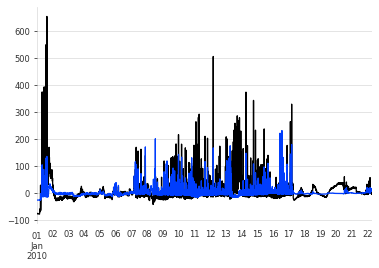

In [10]:
y.plot()

In [11]:
def split_data(x, y, timestamp):
    x_before, x_after = x.split_before(pd.Timestamp(timestamp))
    y_before, y_after = y.split_before(pd.Timestamp(timestamp))
    
    return (x_before, y_before), (x_after, y_after)

In [12]:
before, after  = split_data(x,y, '14-Jan-2010 23:00')

In [13]:
train_tuple, test_tuple, scalers = transform_data(before, [after])
model = run_model(train_tuple)

/home/kjablonk/anaconda3/envs/timeseries_analysis/lib/python3.8/site-packages/torch/random.py:95: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
[2021-04-24 20:28:49,741] INFO | darts.models.torch_forecasting_model | Train dataset contains 4012 samples.
[2021-04-24 20:28:49,741] IN

(2109, 22) (2109, 2)


In [14]:
x_test, y_test = test_tuple[0]

In [15]:
backtest = model.historical_forecasts(y_test,
                          covariates=x_test,
                          start=0.1,
                          forecast_horizon=1,
                          stride=2,
                          retrain=False,
                          verbose=False)

In [16]:
results = parallelized_inference(model, x_test, y_test, repeats=100)

In [27]:
import pickle

In [19]:
with open('results.pkl', 'wb') as handle: 
    pickle.dump(results, handle)

In [23]:
import numpy as np

In [37]:
def summarize_results(results): 
    values = []
    
    for df in results: 
        values.append(df.pd_dataframe().values)
    
    df = df.pd_dataframe()
    columns = df.columns
    
    return pd.DataFrame(np.mean(values, axis=0), columns=columns, index=df.index), pd.DataFrame(np.std(values, axis=0), columns=columns,  index=df.index)

In [38]:
means, stds = summarize_results(results)

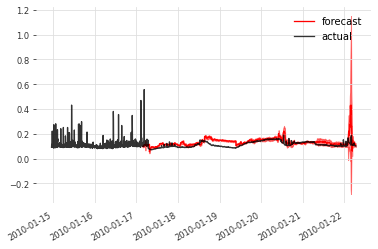

In [65]:
plt.plot(means['0'], c='r', label='forecast')
plt.fill_between(means['0'].index, means['0']-stds['0'], means['0']+stds['0'], alpha=.5, color='r')
y_test['0'].plot(label='actual', alpha=.8)
plt.legend()

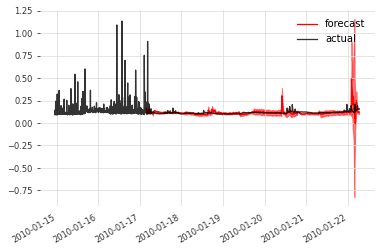

In [64]:
plt.plot(means['1'], c='r', label='forecast')
plt.fill_between(means['1'].index, means['1']-stds['1'], means['1']+stds['1'], alpha=.5, color='r')
y_test['1'].plot(label='actual',  alpha=.8)
plt.legend()

(-0.2, 0.6)

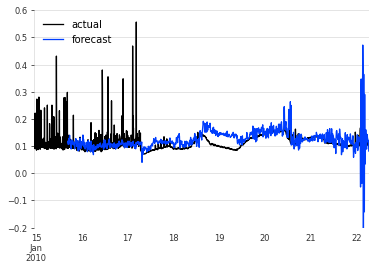

In [17]:
y_test['0'].plot(label='actual')
backtest['0'].plot(label='forecast')
plt.legend()
plt.ylim(-0.2,0.6)
#plt.savefig('2amp.pdf', bbox_inches='tight')

(-0.2, 0.6)

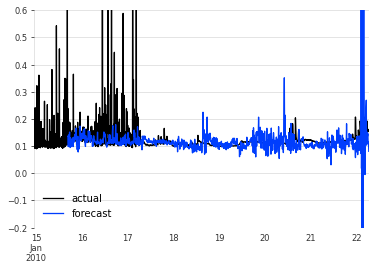

In [18]:
y_test['1'].plot(label='actual')
backtest['1'].plot(label='forecast')
plt.legend()
plt.ylim(-0.2,0.6)
#plt.savefig('piperazine.pdf', bbox_inches='tight')

In [ ]:
y_test['1'].plot(label='actual')
backtest['1'].plot(label='forecast')
plt.legend()
plt.ylim(-0.2, 0.8)

In [ ]:
y_test['2'].plot(label='actual')
backtest['2'].plot(label='forecast')
plt.legend();

In [ ]:
y_test['1'].plot(label='actual')
backtest['1'].plot(label='forecast')
plt.legend();